In [82]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import pickle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
!pip install shap
import shap

In [83]:
# read pickle file into python
infile = open(r'C:\A\Education\Data Science\Ultimate Technologies Inc\part_3_data_exploration','rb')
df= pickle.load(infile)
infile.close()

In [84]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_trip_year,last_trip_month,last_trip_day,active_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,4.7,2014,6,17,yes
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014,5,5,no
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,4.3,2014,1,7,no
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.6,2014,6,29,yes
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.4,2014,3,15,no


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
last_trip_year            50000 non-null int64
last_trip_month           50000 non-null int64
last_trip_day             50000 non-null int64
active_user               50000 non-null object
dtypes: bool(1), datetime64[ns](1), float64(6), int64(4), object(4)
memory usage: 5.8+ MB


In [86]:
# convert feature 'active_user' to binary
df['active_user'] = df['active_user'].map({'yes':1, 'no':0})

In [87]:
df['active_user'].value_counts(dropna=False)

0    31196
1    18804
Name: active_user, dtype: int64

In [88]:
df['city'].value_counts(dropna=False)

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [89]:
# create dummy valuables for the column of city, rename the columns and drop the first and original column
city_dummies = pd.get_dummies(df['city'],drop_first=True).rename(columns=lambda x: 'city_' + str(x))
df = pd.concat([df, city_dummies], axis=1)
df=df.drop(columns=['city',], axis=1)

In [90]:
df['phone'].value_counts(dropna=False)

iPhone     34582
Android    15022
n/a          396
Name: phone, dtype: int64

In [91]:
# create dummy valuables for the column of phone, rename the columns and drop the first and original column
phone_dummies = pd.get_dummies(df['phone'],drop_first=True).rename(columns=lambda x: 'phone_' + str(x))
df = pd.concat([df, phone_dummies], axis=1)
df=df.drop(columns=['phone',], axis=1)

In [92]:
df['ultimate_black_user'].value_counts(dropna=False)

False    31146
True     18854
Name: ultimate_black_user, dtype: int64

In [93]:
df['ultimate_black_user']=df['ultimate_black_user'].astype(str)

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null object
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
last_trip_year            50000 non-null int64
last_trip_month           50000 non-null int64
last_trip_day             50000 non-null int64
active_user               50000 non-null int64
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_iPhone              50000 non-null uint8
phone_n/a                 50000 non-null uint8
dtypes: datetime64[ns]

In [95]:
# convert feature 'ultimate_black_user' to binary
df['ultimate_black_user'] = df['ultimate_black_user'].map({'True':1, 'False':0})

In [96]:
df['ultimate_black_user'].value_counts(dropna=False)

0    31146
1    18854
Name: ultimate_black_user, dtype: int64

In [97]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_trip_year,last_trip_month,last_trip_day,active_user,city_King's Landing,city_Winterfell,phone_iPhone,phone_n/a
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,4.7,2014,6,17,1,1,0,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,2014,5,5,0,0,0,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,4.3,2014,1,7,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.6,2014,6,29,1,1,0,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.4,2014,3,15,0,0,1,0,0


In [98]:
df['last_trip_year']=df['last_trip_year'].astype(str)

In [99]:
df['last_trip_month']=df['last_trip_month'].astype(str)

In [100]:
df["last_trip"] = df['last_trip_year'].map(str) + df['last_trip_month']

In [101]:
df['signup_year'] = df['signup_date'].str[:4]

In [102]:
df['signup_month'] = df['signup_date'].str[5:7]

In [103]:
df["signup"] = df['signup_year'].map(str) + df['signup_month']

In [104]:
print(df["signup"])

0        201401
1        201401
2        201401
3        201401
4        201401
5        201401
6        201401
7        201401
8        201401
9        201401
10       201401
11       201401
12       201401
13       201401
14       201401
15       201401
16       201401
17       201401
18       201401
19       201401
20       201401
21       201401
22       201401
23       201401
24       201401
25       201401
26       201401
27       201401
28       201401
29       201401
          ...  
49970    201401
49971    201401
49972    201401
49973    201401
49974    201401
49975    201401
49976    201401
49977    201401
49978    201401
49979    201401
49980    201401
49981    201401
49982    201401
49983    201401
49984    201401
49985    201401
49986    201401
49987    201401
49988    201401
49989    201401
49990    201401
49991    201401
49992    201401
49993    201401
49994    201401
49995    201401
49996    201401
49997    201401
49998    201401
49999    201401
Name: signup, Length: 50

In [105]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,...,last_trip_day,active_user,city_King's Landing,city_Winterfell,phone_iPhone,phone_n/a,last_trip,signup_year,signup_month,signup
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,4.7,...,17,1,1,0,1,0,20146,2014,01,201401
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,...,5,0,0,0,0,0,20145,2014,01,201401
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,4.3,...,7,0,0,0,1,0,20141,2014,01,201401
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.6,...,29,1,1,0,1,0,20146,2014,01,201401
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.4,...,15,0,0,1,0,0,20143,2014,01,201401


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
last_trip_year            50000 non-null object
last_trip_month           50000 non-null object
last_trip_day             50000 non-null int64
active_user               50000 non-null int64
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_iPhone              50000 non-null uint8
phone_n/a                 50000 non-null uint8
last_trip            

In [107]:
df=df.drop(['signup_date','last_trip_date','last_trip_year','last_trip_month','last_trip_day','signup_year','signup_month'],axis=1)

In [108]:
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user,city_King's Landing,city_Winterfell,phone_iPhone,phone_n/a,last_trip,signup
0,4,4.7,1.10,15.4,1,46.2,3.67,4.7,1,1,0,1,0,20146,201401
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,0,0,0,0,20145,201401
2,3,4.3,1.00,0.0,0,100.0,0.77,4.3,0,0,0,1,0,20141,201401
3,9,4.6,1.14,20.0,1,80.0,2.36,4.6,1,1,0,1,0,20146,201401
4,14,4.4,1.19,11.8,0,82.4,3.13,4.4,0,0,1,0,0,20143,201401


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
trips_in_first_30_days    50000 non-null int64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
active_user               50000 non-null int64
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_iPhone              50000 non-null uint8
phone_n/a                 50000 non-null uint8
last_trip                 50000 non-null object
signup                    50000 non-null object
dtypes: float64(6), int64(3), object(2), uint8(4)
memory usage: 4.4+ MB


In [164]:
feature_names=['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','ultimate_black_user','weekday_pct','avg_dist','avg_rating_by_driver',"city_King's Landing",'city_Winterfell','phone_iPhone','phone_n/a','last_trip','signup']

In [165]:
len(feature_names)

14

In [110]:
# Create arrays for the features and the response variable
y = df['active_user'].values
X = df.drop('active_user', axis=1).values

In [114]:
# logistic regresson model (test size=0.25)

# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 20)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier:logreg
logreg = LogisticRegression()

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid,cv=5)

# Fit it to the training data
logreg_cv.fit(X_train,y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameter: {'C': 0.00545559478116852, 'penalty': 'l1'}
Tuned Logistic Regression Accuracy: 0.72016


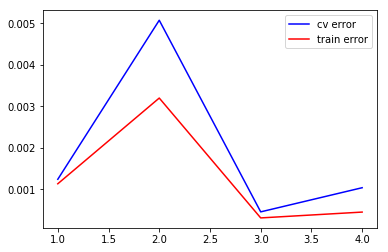

In [142]:
# random forest model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

n_list=[1,2,3,4]
cv_err=[]
train_err=[]
for n in n_list:
    clf=RandomForestClassifier(n_estimators=n)
    clf.fit(Xlr, ylr)
    sig_clf=CalibratedClassifierCV(clf)
    sig_clf.fit(Xlr, ylr)
    
    predict_y=sig_clf.predict_proba(Xtestlr)
    cv_err.append(log_loss(ytestlr, predict_y))
    
    predict_y=sig_clf.predict_proba(Xlr)
    train_err.append(log_loss(ylr, predict_y))

plt.plot(n_list, cv_err, label='cv error', c='b')
plt.plot(n_list, train_err, label='train error', c='r')
plt.legend()
plt.show()

In [143]:
accuracy_score(ytestlr, clf.predict(Xtestlr))

0.9992

In [145]:
clf=RandomForestClassifier(n_estimators=n_list[np.argmin(cv_err)])
clf.fit(Xlr, ylr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [144]:
clf=RandomForestClassifier(n_estimators=n_list[np.argmin(cv_err)], class_weight='balanced')
clf.fit(Xlr, ylr)
np.array([clf.feature_importances_]).T

array([[1.24064811e-02],
       [2.36427984e-03],
       [4.53383363e-03],
       [7.25446748e-02],
       [4.87043933e-03],
       [2.03463289e-02],
       [1.04039620e-02],
       [7.83676418e-03],
       [1.37817009e-02],
       [1.41575069e-03],
       [1.62602606e-02],
       [2.20798179e-04],
       [8.33014726e-01],
       [0.00000000e+00]])

In [173]:
feature_importance=pd.DataFrame((np.hstack((np.array([feature_names]).T, np.array([clf.feature_importances_]).T))), columns=['feature', 'importance'])

In [174]:
feature_importance['importance']=pd.to_numeric(feature_importance['importance'])

In [175]:
feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
12,last_trip,0.794458
5,weekday_pct,0.062966
8,city_King's Landing,0.045584
2,avg_surge,0.028984
3,surge_pct,0.019236
10,phone_iPhone,0.014953
0,trips_in_first_30_days,0.009352
6,avg_dist,0.008572
4,ultimate_black_user,0.008045
7,avg_rating_by_driver,0.002596
